## lieum.gg

### notebook navigation

[import libraries](#1)

[load source data](#2)

[clean source data](#3)

* [convert features to rates](#to_rates)
* [train test split](#train_test_split)

[RF model](#rf_classifier)
- [hypertune using GridSearchCV](#rf_hypertune)

[XGBoost model](#5)

[SHAP interpretation of XGBoost](#6)

[logistic regression](#7)

[SHAP interpretation of logistic regression](#8)

[load in displayed-on-front-end df from liam_gg.py](#9)

[manipulate front-end df as to append to XGBoost df](#10)

[SHAP interpretation of live player data](#11)


<a class="anchor" id="1"></a>


In [136]:
import sys; print(sys.version)

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
plt.style.use('seaborn-darkgrid')
shap.initjs()

from sklearn import preprocessing, metrics

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from timeit import default_timer as timer

import time

%matplotlib inline
#see all columns/rows
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)

3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]


<a class="anchor" id="2"></a>

load data

In [7]:
#read in data
m_D = pd.read_pickle('./data/matchData.pkl')
w_D =  pd.read_pickle('./data/matchWinnerData.pkl')
#l_D = pd.read_pickle('/Users/liamisaacs/Desktop/github repositories/personalwebsite/data/match_loser_data_version1.pickle')

<a class="anchor" id="3"></a>

data cleaning

#see all columns/rows
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)

In [10]:
#drop un-necessary columns
df1.drop(columns=['gameType','mapId', 'platformId','seasonId','status.message',
                    'status.status_code','vilemawKills','dominionVictoryScore'], inplace=True)

In [12]:
df1.head(2)

,gameCreation,gameDuration,gameId,gameMode,gameVersion,participantIdentities,participants,queueId,teamId,win,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,towerKills,inhibitorKills,baronKills,dragonKills,riftHeraldKills,bans
0,1.585155e+12,1323.0,4.247263e+09,CLASSIC,10.6.314.4405,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",420.0,200,Win,False,True,True,False,True,True,9,1,0,3,2,"[{'championId': 523, 'pickTurn': 6}, {'champio..."
1,1.585152e+12,1317.0,4.247156e+09,CLASSIC,10.6.314.4405,"[{'participantId': 1, 'player': {'platformId':...","[{'participantId': 1, 'teamId': 100, 'champion...",420.0,100,Win,False,False,False,False,True,True,4,0,0,2,2,"[{'championId': 523, 'pickTurn': 1}, {'champio..."


In [15]:
#filter to ranked solo 5v5 matches (there are various match types)
df1 = df1[df1['queueId'] == 420]
print("# of observations in uncleaned data:",df1.shape)

# of observations in uncleaned data: (78172, 22)


In [16]:
df2 = pd.DataFrame()

In [18]:
#fetch needed data from the 'participants' column entries, which are JSON objects
#these data are per player statistics that will inform our analysis
j = ['kills', 
     'deaths', 'assists', 'largestKillingSpree', 'largestMultiKill', 'killingSprees', 
     'longestTimeSpentLiving', 'doubleKills', 'tripleKills', 'quadraKills', 'pentaKills', 
     'totalDamageDealt', 'magicDamageDealt', 'physicalDamageDealt', 'trueDamageDealt', 
     'largestCriticalStrike', 'totalDamageDealtToChampions', 'magicDamageDealtToChampions', 
     'physicalDamageDealtToChampions', 'trueDamageDealtToChampions', 'totalHeal', 
     'totalUnitsHealed', 'damageSelfMitigated', 'damageDealtToObjectives', 'damageDealtToTurrets',
     'visionScore', 'timeCCingOthers', 'totalDamageTaken', 'magicalDamageTaken', 
     'physicalDamageTaken', 'trueDamageTaken', 'goldEarned', 'goldSpent', 'turretKills', 
     'inhibitorKills', 'totalMinionsKilled', 'neutralMinionsKilled', 'neutralMinionsKilledTeamJungle',
     'neutralMinionsKilledEnemyJungle', 'totalTimeCrowdControlDealt', 'champLevel', 
     'visionWardsBoughtInGame', 'wardsPlaced', 'wardsKilled', 
     'firstBloodKill', 'firstBloodAssist', 'firstTowerKill', 'firstTowerAssist', 
     'firstInhibitorKill', 'firstInhibitorAssist']
for col in j:
    df2[col] = df1['participants'].map(lambda x:
          ''.join(str(i['stats'][col]) for i in x  if i['participantId'] == 1 and col in i['stats']
                  )
                )

In [21]:
df2.head(5)

,kills,deaths,assists,largestKillingSpree,largestMultiKill,killingSprees,longestTimeSpentLiving,doubleKills,tripleKills,quadraKills,pentaKills,totalDamageDealt,magicDamageDealt,physicalDamageDealt,trueDamageDealt,largestCriticalStrike,totalDamageDealtToChampions,magicDamageDealtToChampions,physicalDamageDealtToChampions,trueDamageDealtToChampions,totalHeal,totalUnitsHealed,damageSelfMitigated,damageDealtToObjectives,damageDealtToTurrets,visionScore,timeCCingOthers,totalDamageTaken,magicalDamageTaken,physicalDamageTaken,trueDamageTaken,goldEarned,goldSpent,turretKills,inhibitorKills,totalMinionsKilled,neutralMinionsKilled,neutralMinionsKilledTeamJungle,neutralMinionsKilledEnemyJungle,totalTimeCrowdControlDealt,champLevel,visionWardsBoughtInGame,wardsPlaced,wardsKilled,firstBloodKill,firstBloodAssist,firstTowerKill,firstTowerAssist,firstInhibitorKill,firstInhibitorAssist
0,3,6,3,2,1,1,564,0,0,0,0,71369,56332,13037,1999,0,10844,8926,1918,0,4006,1,6742,1055,1008,14,12,17255,5282,11203,770,6844,6710,0,0,133,0,0,0,19,12,3,6,1,True,False,False,False,False,False
1,3,5,2,2,1,1,351,0,0,0,0,91081,3316,83719,4045,0,16662,916,15033,712,1267,1,5791,1885,1885,14,1,15543,4239,10620,684,8452,7900,1,0,166,4,0,4,33,14,4,11,1,False,False,False,False,,
2,0,4,1,0,0,0,354,0,0,0,0,19098,0,17614,1483,1483,5167,0,5167,0,2119,2,2996,1600,0,14,19,6494,1789,4506,198,3228,3000,0,0,11,0,0,0,82,7,2,9,1,False,False,False,False,False,False
3,4,9,11,2,1,1,457,0,0,0,0,35821,16894,11345,7581,0,10158,6337,2176,1644,2673,1,61798,1021,68,84,74,27058,4996,17835,4226,9592,9475,0,0,52,0,0,0,377,14,11,58,9,False,False,False,False,,
4,7,12,12,2,1,1,377,0,0,0,0,269340,41262,224449,3628,782,36749,8910,26824,1014,8355,3,19728,26607,8067,21,4,33275,13606,16527,3142,18545,20205,2,1,223,59,45,10,114,17,1,9,8,True,False,False,False,False,False


In [26]:
print("df2 is our 'pivoted' df using information stored in the previous column 'participants'\n")
print("'participants' is each player of the 5v5 game-mode; *the order is random*")
print("we can then choose just pivoted data from 'player1', which will always be random,")
print("and even if it's all from 'winnersMatchData', this is misleading, since the player")
print("could've won or lost\n")
print("# of observations in df2",df2.shape)

df2 is our 'pivoted' df using information stored in the previous column 'participants'

'participants' is each player of the 5v5 game-mode; *the order is random*
we can then choose just pivoted data from 'player1', which will always be random,
and even if it's all from 'winnersMatchData', this is misleading, since the player
could've won or lost

# of observations in df2 (78172, 50)


In [56]:
#make a copy since df2 takes a while to create (~5-10 minutes for me)
df3 = df2.copy()

In [57]:
#merge in game duration (so we can use rates later on)
game_dur = df1['gameDuration'] #game_dur is a pandas Series
df3 = pd.concat([df2, game_dur], axis=1)

#drop games that lasted <10 minutes (measured in seconds)
#DOMAIN KNOWLEDGE: you can have players enter the game who are afk, 
#this provides the disadvantaged team the option to 'surrender' the game,
#and none of the statistics will be meaningful.

df3 = df3.loc[df3['gameDuration'] >= 10*60,:]
print("got rid of", np.absolute(df3.shape[0]-df2.shape[0])," rows")

got rid of 1222  rows


In [58]:
#add in win column
df3['win'] = df1['participants'].map(lambda x:
                                          ' '.join(str(i['stats']['win']) for i in x
                                                      if i['participantId'] == 1 
                                                      ))

In [60]:
#replace True/False with 1/0, except for win, which we leave as True/False
t_f_col = ['win']
binary_t_f_col = ['firstBloodKill', 'firstTowerKill', 'firstBloodAssist',
          'firstTowerAssist', 'firstInhibitorKill', 'firstInhibitorAssist']
for col in t_f_col:
    df3[col].replace({'False': False, 'True': True}, inplace=True)
for col in binary_t_f_col:
    df3[col].replace({'False': 0, 'True': 1}, inplace=True)
print("true/false strings replaced with binary or boolean values!")

true/false strings replaced with binary or boolean values!


In [80]:
#for some reason, these "firstXY" columns sometimes are empty
#what could have happened, is the enemy team surrendered before any inhibitors could be killed
#or, the player's team surrendered before any inhibitors could be killed

#so, we will impute 0, since surrendering a game before killing an inhibitor is just the same
#as not killing an inhibitor

#even though it is less likely, this is also present in tower kills (it makes sense, since
#towers are easily to kill)

df3.loc[:,'firstBloodKill':'win'].head(10)

,firstBloodKill,firstBloodAssist,firstTowerKill,firstTowerAssist,firstInhibitorKill,firstInhibitorAssist,gameDuration,win
0,1,0,0,0,0,0,1323.0,False
1,0,0,0,0,,,1317.0,True
2,0,0,0,0,0,0,932.0,False
3,0,0,0,0,,,2098.0,False
4,1,0,0,0,0,0,2344.0,True
5,0,0,0,1,0,1,1567.0,True
6,0,0,0,1,0,0,1686.0,False
7,0,0,0,0,0,0,1588.0,True
8,0,0,1,0,0,0,1618.0,True
9,0,0,1,0,,,1126.0,True


In [90]:
convert = ['firstBloodKill','firstBloodAssist','firstTowerKill', 'firstTowerAssist', 'firstInhibitorKill', 'firstInhibitorAssist']
for col in convert:
    df3[col].replace('', np.nan, inplace=True)

In [96]:
print("# of games with empty 'firstInhibitorKill' values",df3.firstInhibitorKill.isna().sum())
print("(games surrendered by either team before an inhibitor could be killed)\n")

print("# of games with empty 'firstInhibitorAssist' values",df3.firstInhibitorAssist.isna().sum())
print("(games surrendered by either team before an inhibitor kill could be assisted)\n")

print("# of games with empty 'firstTowerKill' values",df3.firstTowerKill.isna().sum())
print("(games surrendered by either team before a tower could be killed)\n")

print("# of games with empty 'firstTowerAssist' values",df3.firstTowerAssist.isna().sum())
print("(games surrendered by either team before a tower kill could be assisted)\n")

print("# of games with empty 'firstBloodKill' values",df3.firstBloodKill.isna().sum())
print("# of games with empty 'firstBloodAssist' values",df3.firstBloodAssist.isna().sum())

# of games with empty 'firstInhibitorKill' values 19036
(games surrendered by either team before an inhibitor could be killed)

# of games with empty 'firstInhibitorAssist' values 19036
(games surrendered by either team before an inhibitor kill could be assisted)

# of games with empty 'firstTowerKill' values 46
(games surrendered by either team before a tower could be killed)

# of games with empty 'firstTowerAssist' values 46
(games surrendered by either team before a tower kill could be assisted)

# of games with empty 'firstBloodKill' values 0
# of games with empty 'firstBloodAssist' values 0


In [97]:
for col in convert:
    df3[col].fillna(0, inplace=True)
print("above^ issues (total = ~20k or ~30% of data) imputed with 0 values instead of NA")

above^ issues (total = ~20k or ~30% of data) imputed with 0 values instead of NA


In [100]:
print("Double-check that the above worked")
print("# of games with NA 'firstInhibitorKill' values",df3.firstInhibitorKill.isna().sum())
print("# of games with NA 'firstInhibitorAssist' values",df3.firstInhibitorAssist.isna().sum())
print("# of games with NA 'firstTowerKill' values",df3.firstTowerKill.isna().sum())
print("# of games with NA 'firstTowerAssist' values",df3.firstTowerAssist.isna().sum())
print("# of games with NA 'firstBloodKill' values",df3.firstBloodKill.isna().sum())
print("# of games with NA 'firstBloodAssist' values",df3.firstBloodAssist.isna().sum())

Double-check that the above worked
# of games with NA 'firstInhibitorKill' values 0
# of games with NA 'firstInhibitorAssist' values 0
# of games with NA 'firstTowerKill' values 0
# of games with NA 'firstTowerAssist' values 0
# of games with NA 'firstBloodKill' values 0
# of games with NA 'firstBloodAssist' values 0


In [101]:
#create copy for convenience
df = df3.copy()

In [102]:
df
#create csv file of df for convenience
liamgg_data = df.to_csv('liamgg_data.csv', index = True) 

In [ ]:
#later on you can just run
#df = pd.read_csv('path_to_df')

<a class="anchor" id="to_rates"></a>

Convert features to rates

In [116]:
X_ = df.drop(["win"], axis=1)
y_ = df["win"]

#Convert string-based features (every column) to numbers
for col in list(X_.columns):
    X_[col] = pd.to_numeric(X_[col])

In [117]:
#Define features we want to convert to rates
rate_features = [
    "kills", "deaths", "assists", "killingSprees", "doubleKills",
    "tripleKills", "quadraKills", "pentaKills", 
    "totalDamageDealt", "magicDamageDealtToChampions", "physicalDamageDealt", "trueDamageDealt",
    "totalDamageDealtToChampions", "magicDamageDealtToChampions", "physicalDamageDealtToChampions", "trueDamageDealtToChampions",
    "trueDamageDealtToChampions", "magicDamageDealt",
    "totalHeal", "totalUnitsHealed", "damageDealtToObjectives", "timeCCingOthers", "totalDamageTaken",
    "magicalDamageTaken" , "physicalDamageTaken", "trueDamageTaken", "goldEarned", "goldSpent",
    "totalMinionsKilled", "neutralMinionsKilled", "neutralMinionsKilledTeamJungle",
    "neutralMinionsKilledEnemyJungle", "totalTimeCrowdControlDealt", "visionWardsBoughtInGame", 
    "wardsPlaced", "wardsKilled"
]

#Convery rate features to per minute rates of the game
for feature_name in rate_features:
    X_[feature_name] /= X_["gameDuration"] / 60 # per minute rate
    
X_["longestTimeSpentLiving"] /= X_["gameDuration"]

# Define friendly names for the features
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingSprees": "Killing sprees per min.",
    "longestTimeSpentLiving": "Longest time living as % of game",
    "doubleKills": "Double kills per min.",
    "tripleKills": "Triple kills per min.",
    "quadraKills": "Quadra kills per min.",
    "pentaKills": "Penta kills per min.",
    "totalDamageDealt": "Total damage dealt per min.",
    "magicDamageDealt": "Magic damage dealt per min.",
    "physicalDamageDealt": "Physical damage dealt per min.",
    "trueDamageDealt": "True damage dealt per min.",
    "totalDamageDealtToChampions": "Total damage to champions per min.",
    "magicDamageDealtToChampions": "Magic damage to champions per min.",
    "physicalDamageDealtToChampions": "Physical damage to champions per min.",
    "trueDamageDealtToChampions": "True damage to champions per min.",
    "totalHeal": "Total healing per min.",
    "totalUnitsHealed": "Total units healed per min.",
    "damageDealtToObjectives": "Damage to objects per min.",
    "timeCCingOthers": "Time spent with crown control per min.",
    "totalDamageTaken": "Total damage taken per min.",
    "magicalDamageTaken": "Magic damage taken per min.",
    "physicalDamageTaken": "Physical damage taken per min.",
    "trueDamageTaken": "True damage taken per min.",
    "goldEarned": "Gold earned per min.",
    "goldSpent": "Gold spent per min.",
    "totalMinionsKilled": "Total minions killed per min.",
    "neutralMinionsKilled": "Neutral minions killed per min.",
    "neutralMinionsKilledTeamJungle": "Own jungle kills per min.",
    "neutralMinionsKilledEnemyJungle": "Enemy jungle kills per min.",
    "totalTimeCrowdControlDealt": "Total crown control time dealt per min.",
    "visionWardsBoughtInGame": "Pink wards bought per min.",
    "wardsPlaced": "Wards placed per min.",
    "wardsKilled": "Wards killed per min.",
    "turretKills": "# of turret kills",
    "inhibitorKills": "# of inhibitor kills",
    "damageDealtToTurrets": "Damage to turrets",
    "largestKillingSpree": "Largest killing spree",
    "largestMultiKill": "Largest multi kill",
    "largestCriticalStrike": "Largest critical strike", 
    "damageSelfMitigated": "Self-mitigated damage",
    "visionScore": "Vision score",
    "firstBloodKill": "First blood",
    "firstBloodAssist": "First blood (assist)",
    "firstTowerKill": "First tower",
    "firstTowerAssist": "First tower (assist)",
    "firstInhibitorKill": "First inhibitor",
    "firstInhibitorAssist": "First inhibitor (assist)",
    "gameDuration": "Game duration"
}
#Replace columns with nicer names
feature_names = [full_names.get(n, n) for n in X_.columns]
X_.columns = feature_names

In [118]:
X_.head(2)

,Kills per min.,Deaths per min.,Assists per min.,Largest killing spree,Largest multi kill,Killing sprees per min.,Longest time living as % of game,Double kills per min.,Triple kills per min.,Quadra kills per min.,Penta kills per min.,Total damage dealt per min.,Magic damage dealt per min.,Physical damage dealt per min.,True damage dealt per min.,Largest critical strike,Total damage to champions per min.,Magic damage to champions per min.,Physical damage to champions per min.,True damage to champions per min.,Total healing per min.,Total units healed per min.,Self-mitigated damage,Damage to objects per min.,Damage to turrets,Vision score,Time spent with crown control per min.,Total damage taken per min.,Magic damage taken per min.,Physical damage taken per min.,True damage taken per min.,Gold earned per min.,Gold spent per min.,# of turret kills,# of inhibitor kills,Total minions killed per min.,Neutral minions killed per min.,Own jungle kills per min.,Enemy jungle kills per min.,Total crown control time dealt per min.,champLevel,Pink wards bought per min.,Wards placed per min.,Wards killed per min.,First blood,First blood (assist),First tower,First tower (assist),First inhibitor,First inhibitor (assist),Game duration
0,0.136054,0.272109,0.136054,2,1,0.045351,0.426304,0.0,0.0,0.0,0.0,3236.689342,2554.739229,591.247166,90.657596,0,491.791383,18.358606,86.984127,0.000000,181.678005,0.045351,6742,47.845805,1008,14,0.544218,782.539683,239.546485,508.072562,34.920635,310.385488,304.308390,0,0,6.031746,0.000000,0.0,0.000000,0.861678,12,0.136054,0.272109,0.045351,1,0,0.0,0.0,0.0,0.0,1323.0
1,0.136674,0.227790,0.091116,2,1,0.045558,0.266515,0.0,0.0,0.0,0.0,4149.476082,151.070615,3814.077449,184.282460,0,759.088838,1.901194,684.874715,1.477784,57.722096,0.045558,5791,85.876993,1885,14,0.045558,708.109339,193.120729,483.826879,31.161731,385.056948,359.908884,1,0,7.562642,0.182232,0.0,0.182232,1.503417,14,0.182232,0.501139,0.045558,0,0,0.0,0.0,0.0,0.0,1317.0


<a class="anchor" id="train_test_split"></a>

Train/test split

In [119]:
# create train/validation split
Xt, Xv, yt, yv = train_test_split(X_,y_, test_size=0.2, random_state=10)

In [120]:
#Check null values
Xt.isnull().values.any()

False

In [121]:
Xt.sample(2)

,Kills per min.,Deaths per min.,Assists per min.,Largest killing spree,Largest multi kill,Killing sprees per min.,Longest time living as % of game,Double kills per min.,Triple kills per min.,Quadra kills per min.,Penta kills per min.,Total damage dealt per min.,Magic damage dealt per min.,Physical damage dealt per min.,True damage dealt per min.,Largest critical strike,Total damage to champions per min.,Magic damage to champions per min.,Physical damage to champions per min.,True damage to champions per min.,Total healing per min.,Total units healed per min.,Self-mitigated damage,Damage to objects per min.,Damage to turrets,Vision score,Time spent with crown control per min.,Total damage taken per min.,Magic damage taken per min.,Physical damage taken per min.,True damage taken per min.,Gold earned per min.,Gold spent per min.,# of turret kills,# of inhibitor kills,Total minions killed per min.,Neutral minions killed per min.,Own jungle kills per min.,Enemy jungle kills per min.,Total crown control time dealt per min.,champLevel,Pink wards bought per min.,Wards placed per min.,Wards killed per min.,First blood,First blood (assist),First tower,First tower (assist),First inhibitor,First inhibitor (assist),Game duration
84710,0.369990,0.154162,0.246660,5,2,0.092497,0.327338,0.061665,0.0,0.0,0.0,6311.130524,194.614594,5932.199383,184.285714,1034,697.399794,1.942161,630.339157,0.125485,106.279548,0.123330,11894,790.637205,4013,37,0.123330,660.616650,275.827338,366.628983,18.129496,486.536485,478.674203,3,0,6.721480,1.171634,0.61665,0.184995,2.004111,16,0.061665,0.308325,0.339157,0,0,0.0,0.0,0.0,1.0,1946.0
15168,0.255537,0.051107,0.511073,5,1,0.051107,0.160136,0.000000,0.0,0.0,0.0,5564.974446,3825.127768,1229.335605,510.511073,0,800.902896,35.373757,63.168654,2.327255,193.952300,0.051107,3805,1316.166951,2555,34,1.022147,464.974446,150.051107,314.923339,0.000000,476.166951,424.190801,3,0,0.664395,5.161840,2.29983,1.328790,5.264055,12,0.102215,0.459966,0.255537,0,0,0.0,0.0,0.0,0.0,1174.0


In [122]:
print("# of observations in X_train dataset: ",Xt.shape)
print("# of observations in y_train dataset: ",yt.shape)
print("# of observations in X_val dataset: ", Xv.shape)
print("# of observations in y_val dataset: ", yv.shape)

# of observations in X_train dataset:  (61560, 51)
# of observations in y_train dataset:  (61560,)
# of observations in X_val dataset:  (15390, 51)
# of observations in y_val dataset:  (15390,)


<a class="anchor" id="rf_classifier"></a>

### RandomForest (RF) Classifier

Hypertune RF model using grid search cross-validation (GridSearchCV)

In [123]:
rf = RandomForestClassifier()

#use grid search to find best parameters
parameters = {
    "n_estimators":[5,10,50,100,250],
    "max_depth":[2,4,8,16,32,None]   
}

cv = GridSearchCV(rf,parameters,cv=5)
cv.fit(Xt,yt.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 8, 16, 32, None],
                         'n_estimators': [5, 10, 50, 100, 250]})

In [125]:
#display results of RF gridsearch
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

<a class="anchor" id="rf_hypertune"></a>

In [126]:
display(cv)

Best parameters are: {'max_depth': 32, 'n_estimators': 250}


0.795 + or -0.013 for the {'max_depth': 2, 'n_estimators': 5}
0.817 + or -0.014 for the {'max_depth': 2, 'n_estimators': 10}
0.826 + or -0.003 for the {'max_depth': 2, 'n_estimators': 50}
0.824 + or -0.007 for the {'max_depth': 2, 'n_estimators': 100}
0.828 + or -0.005 for the {'max_depth': 2, 'n_estimators': 250}
0.839 + or -0.004 for the {'max_depth': 4, 'n_estimators': 5}
0.845 + or -0.004 for the {'max_depth': 4, 'n_estimators': 10}
0.856 + or -0.004 for the {'max_depth': 4, 'n_estimators': 50}
0.858 + or -0.004 for the {'max_depth': 4, 'n_estimators': 100}
0.859 + or -0.003 for the {'max_depth': 4, 'n_estimators': 250}
0.869 + or -0.004 for the {'max_depth': 8, 'n_estimators': 5}
0.877 + or -0.002 for the {'max_depth': 8, 'n_estimators': 10}
0.884 + or -0.002 for the {'max_depth': 8, 'n_estimators': 50}
0.885 + or -0.003 for the {'max_depth': 8, 'n_estimators': 100}
0.886 + or -0.002 for the {'max_depth': 8, 'n_estimato

Run RF model with best hyperparameters

In [127]:
#run model
ntrees = 250
rf = RandomForestClassifier(n_estimators=ntrees, 
                            n_jobs=-1,
                            max_depth=32
                           )
start = timer()
rf.fit(Xt, yt)
stop = timer()
print(f"RF fit time with {len(Xt)} records and {ntrees} trees = {(stop-start):.2f}s")

RF fit time with 61560 records and 250 trees = 12.88s


In [128]:
rf

RandomForestClassifier(max_depth=32, n_estimators=250, n_jobs=-1)

In [129]:
rf_cv_score = cross_val_score(rf, Xt, yt, cv=10)

In [130]:
y_pred = rf.predict(Xv)
cnf_matrix = confusion_matrix(yv, y_pred)
print("=== CONFUSION MATRIX ===")
print(cnf_matrix)
print('\n')

print("=== CLASSIFICATION REPORT === ")
print(classification_report(yv, y_pred))
print('\n')
print("=== All AUC Scores ===")
#print(rf_cv_score)
print('\n')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest: ", rf_cv_score.mean())

=== CONFUSION MATRIX ===
[[6983  779]
 [ 709 6919]]


=== CLASSIFICATION REPORT === 
              precision    recall  f1-score   support

       False       0.91      0.90      0.90      7762
        True       0.90      0.91      0.90      7628

    accuracy                           0.90     15390
   macro avg       0.90      0.90      0.90     15390
weighted avg       0.90      0.90      0.90     15390



=== All AUC Scores ===


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.9020467836257311


High precision/recall scores are expected since we are predicting a game outcome, from the game outcome

<AxesSubplot:>

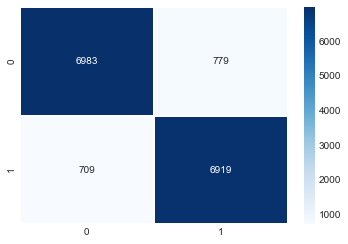

In [138]:
cf_matrix = confusion_matrix(yv, y_pred)
sns.heatmap(cnf_matrix, linewidths=1, annot=True, fmt='g', cmap='Blues')

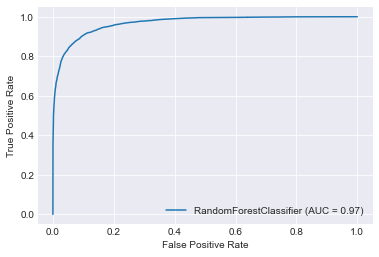

In [139]:
metrics.plot_roc_curve(rf, Xv, yv)  
plt.show()                                   

In [158]:
#get SHAP values to use to interpret/debug model
Xv_ = Xv
Xt_ = Xt
start = timer()
explainer = shap.TreeExplainer(rf, Xt_, feature_perturbation="interventional")
shap_values = explainer.shap_values(Xv_)
stop = timer()

100%|===================| 30775/30780 [104:04<00:01]        

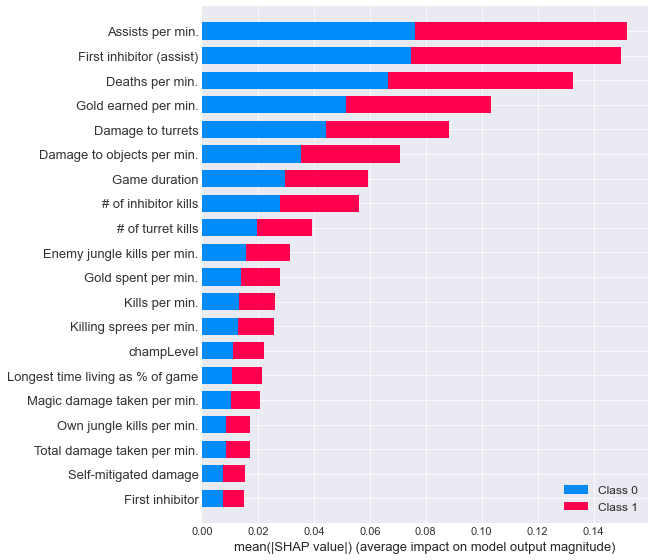

In [159]:
shap.summary_plot(shap_values, Xv)

## XGBoost Classifier

In [141]:
#for XGBoost (win must be 0 or 1)
Xt_boost = Xt
Xv_boost = Xv

dt = xgb.DMatrix(Xt, label=yt.values, enable_categorical=True)
dv = xgb.DMatrix(Xv, label=yv.values)

In [142]:
params = {
    "eta": 0.5,
    "max_depth": 4,
    "objective": "binary:logistic",
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": "logloss"
}
model = xgb.train(params, dt, 35, [(dt, "train"), (dv, "valid")], early_stopping_rounds=5, verbose_eval=35)

[16:22:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.50225	valid-logloss:0.50363
[34]	train-logloss:0.18546	valid-logloss:0.20799


In [143]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)

In [144]:
shap.force_plot(explainer.expected_value, shap_values[0,:-1], Xv.iloc[0,:-1])

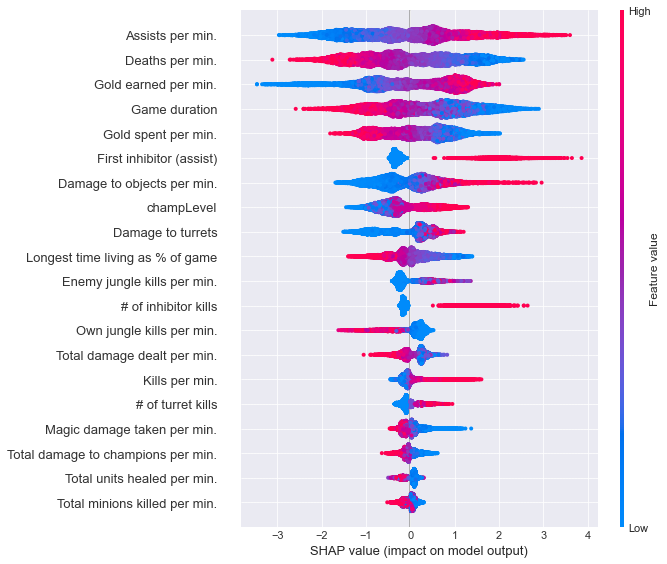

In [145]:
shap.summary_plot(shap_values, Xv)

Bayesian optimization of XGBoost hyperparameters

In [146]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


In [147]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }


In [148]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( Xt, yt), ( Xv, yv)]
    
    clf.fit(Xt, yt,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(Xv)
    accuracy = accuracy_score(yv, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [149]:
#trail-test a bunch of hyperparameters
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



SCORE:                                                 
0.8686809616634178                                     
SCORE:                                                                            
0.8645873944119559                                                                
SCORE:                                                                            
0.8635477582846004                                                                
SCORE:                                                                            
0.869785575048733                                                                 
SCORE:                                                                            
0.8662118258609487                                                               
SCORE:                                                                           
0.8657569850552307                                                               
SCORE:                                                       

SCORE:                                                                             
0.8693957115009746                                                                 
SCORE:                                                                             
0.8671864847303444                                                                 
SCORE:                                                                             
0.8680961663417803                                                                 
SCORE:                                                                             
0.8690708252111761                                                                 
SCORE:                                                                             
0.8666666666666667                                                                 
SCORE:                                                                             
0.8643924626380767                                                          

0.8695906432748538                                                                 
SCORE:                                                                             
0.8686809616634178                                                                 
SCORE:                                                                             
0.8687459389213775                                                                 
100%|██████████| 100/100 [04:23<00:00,  2.63s/trial, best loss: -0.8708901884340481]


In [150]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.6616510019678549, 'gamma': 1.9301871141913935, 'max_depth': 14.0, 'min_child_weight': 6.0, 'reg_alpha': 43.0, 'reg_lambda': 0.8263680263092955}


In [151]:
#for XGBoost (win must be 0 or 1)
Xt_boost = Xt
Xv_boost = Xv

dt = xgb.DMatrix(Xt, label=yt.values, enable_categorical=True)
dv = xgb.DMatrix(Xv, label=yv.values)

In [152]:
params = {
    "eta": 0.5,
    "max_depth": 8,
    'min_child_weight': 1,
    "objective": "binary:logistic",
    "silent": 1,
    "base_score": np.mean(yt),
    "eval_metric": "logloss",
    'colsample_bytree': 0.7434869381604485, 
    'gamma': 1.1053886968419446,
    'reg_alpha': 49.0, 
    'reg_lambda': 0.9997899615065826
}
tuned_model = xgb.train(params, dt, 35, [(dt, "train"), (dv, "valid")], early_stopping_rounds=5, verbose_eval=35)

[16:28:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-logloss:0.49469	valid-logloss:0.50026
[34]	train-logloss:0.17492	valid-logloss:0.20533


In [161]:
explainer = shap.TreeExplainer(tuned_model)
shap_values_boost = explainer.shap_values(Xv_boost)

In [162]:
shap.force_plot(explainer.expected_value, shap_values_boost[0,:-1], Xv_boost.iloc[0,:-1])

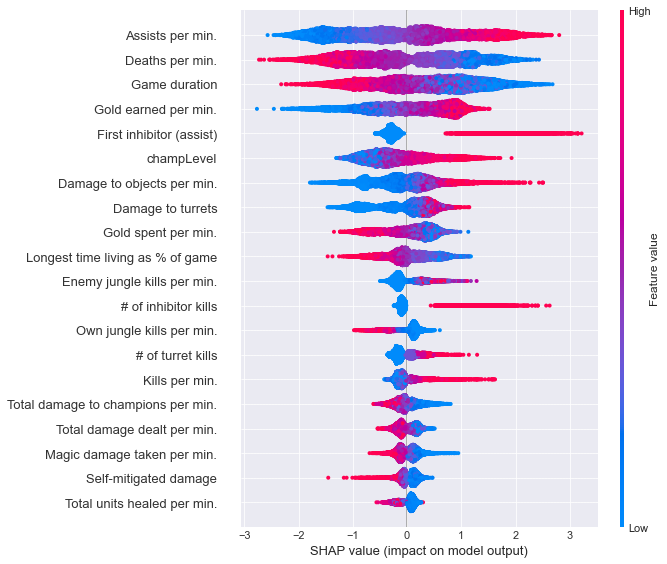

In [163]:
shap.summary_plot(shap_values_boost, Xv_boost)

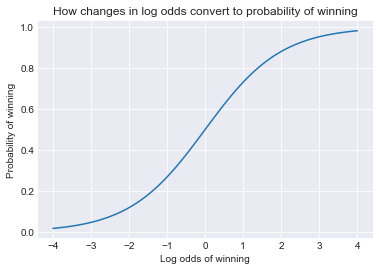

In [157]:
xs = np.linspace(-4,4,100)
plt.xlabel("Log odds of winning")
plt.ylabel("Probability of winning")
plt.title("How changes in log odds convert to probability of winning")
plt.plot(xs, 1/(1+np.exp(-xs)))
plt.show()

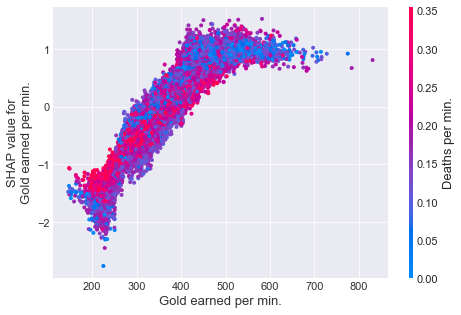

In [164]:
shap.dependence_plot("Gold earned per min.", shap_values_boost, Xv, interaction_index="Deaths per min.")

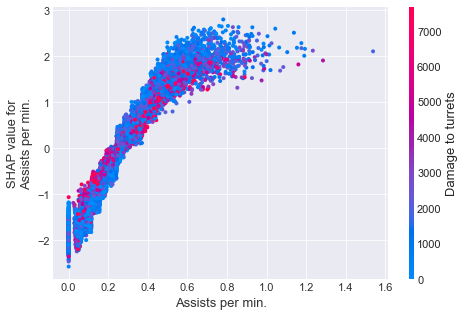

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


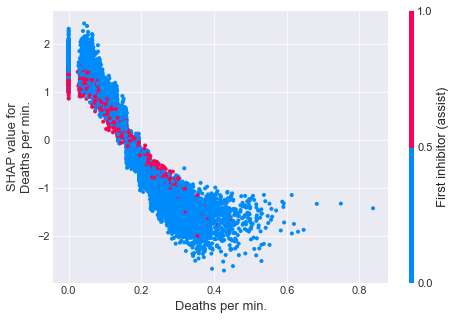

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


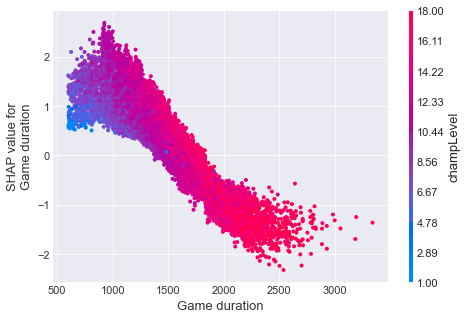

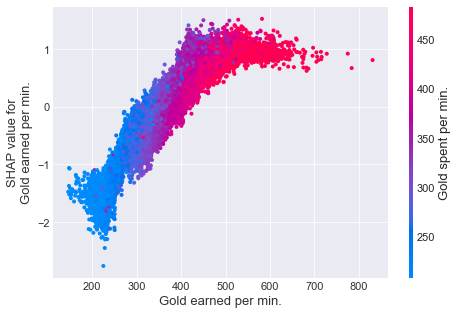

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


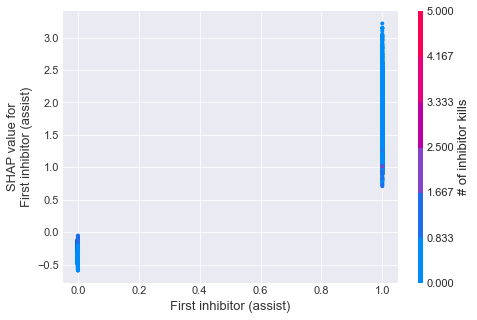

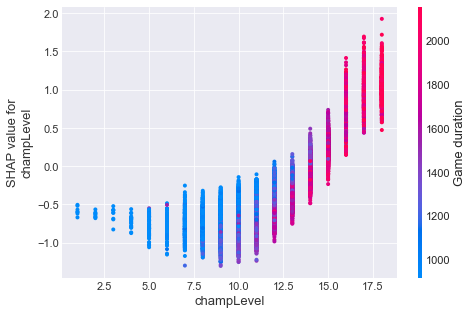

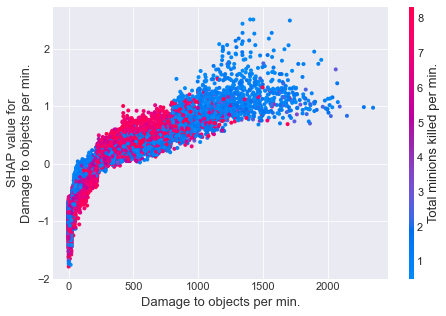

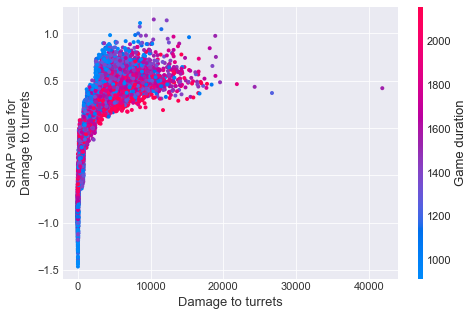

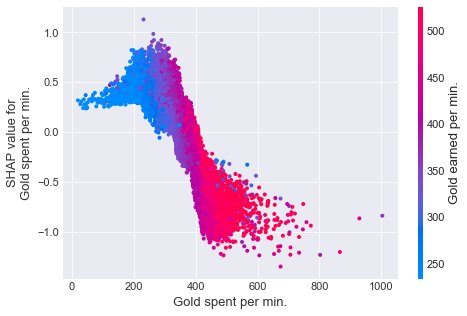

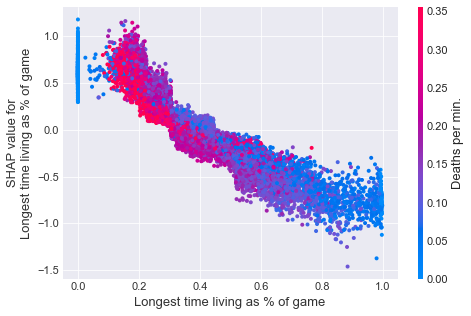

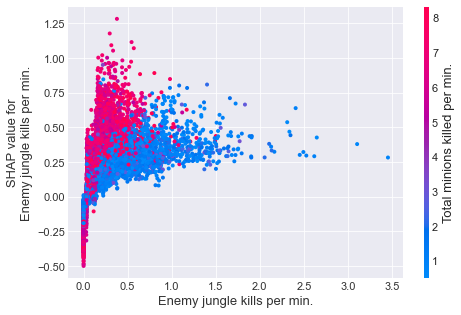

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


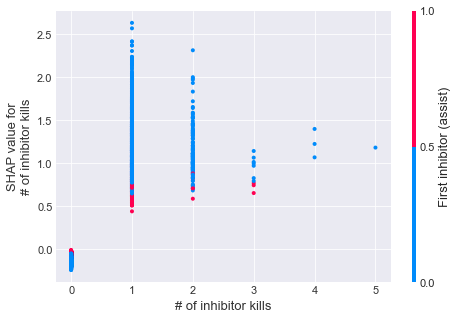

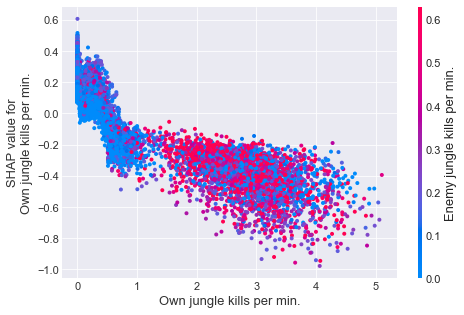

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


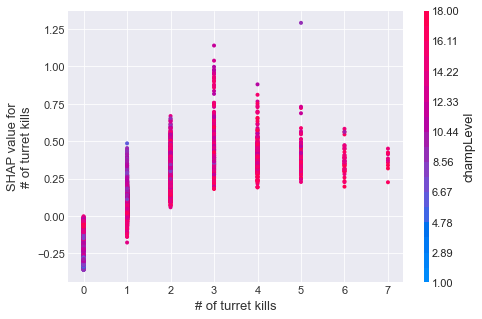

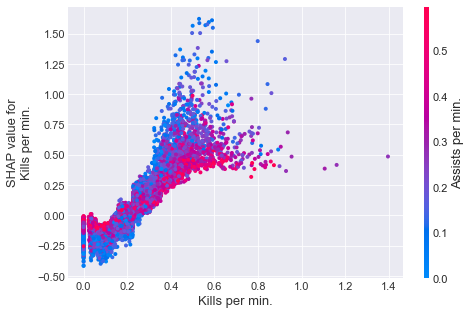

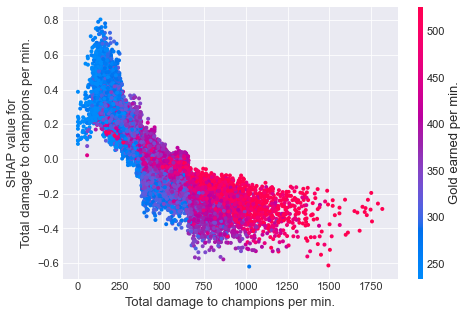

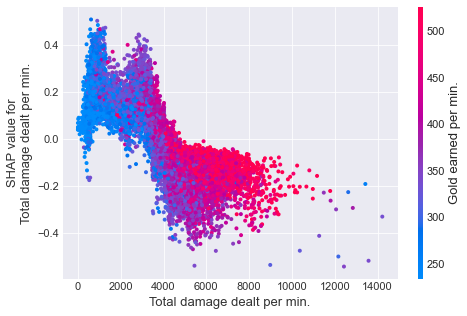

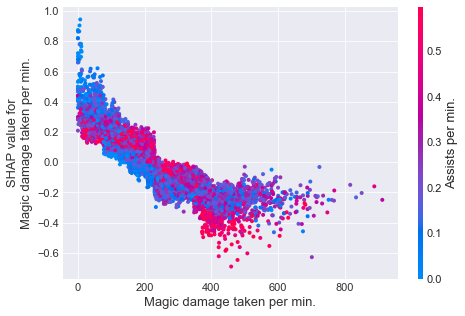

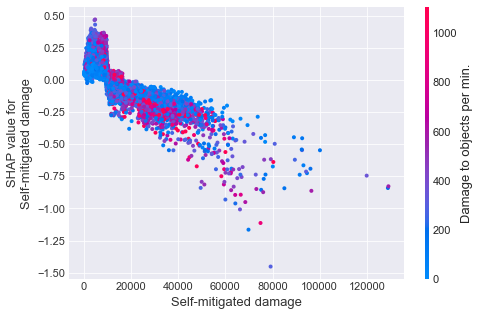

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


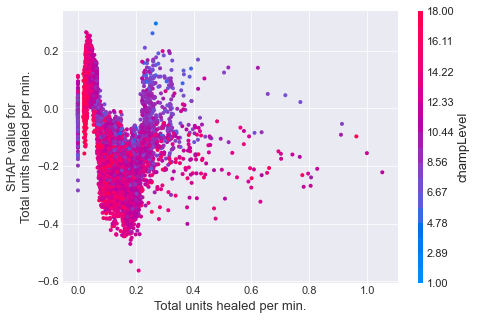

In [166]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values_boost), 0))

# make SHAP plots of the three most important features
for i in range(20):
    shap.dependence_plot(top_inds[i], shap_values_boost, Xv)

In [232]:
from riotwatcher import LolWatcher, ApiError
import pandas as pd
import numpy as np
import pprint
from datetime import datetime


# Fetching game data

class game_info_by_match_id():
    """
    Returns df of user info from a given match (so far).
    """
    #define private variables to use in class

    def __init__(self, api_key, name, region, gamemode, gameid):
        #upon calling the class we pass in a bunch of things to initialize^
        self.api_key = api_key
        self.name = name
        self.region = region
        self.gamemode = gamemode
        self.gameid = gameid
        watcher = LolWatcher(self.api_key)
        self.user = watcher.summoner.by_name(region, name)

    def rank_stats(self):
        watcher = LolWatcher(self.api_key)

        #league, division, games played, etc.
        encrypted_summoner_id = self.user['id']
        self.rank_stats = watcher.league.by_summoner(self.region, self.user['id'])
        return self.rank_stats

    def match_data(self):
        watcher = LolWatcher(self.api_key)

        self.matches = watcher.match.matchlist_by_account(self.region, self.user['accountId'])

        self.match_data = watcher.match.by_id(self.region, self.gameid)
        m = self.match_data

        #n is for each "participant" or player in the match
        def gd():
            n = [] #dump raw stats into here from participants
            for row in m['participants']:
                m_row = {}
                m_row['champion'] = row['championId']
                m_row['spell1'] = row['spell1Id']
                m_row['spell2'] = row['spell2Id']
                m_row['teamId'] = row['teamId']
                win_lose = row['stats']['win']
                if win_lose == True:
                    win_lose = '胜利'
                else:
                    win_lose = '失败'
                m_row['win'] = win_lose
                m_row['kills'] = row['stats']['kills']
                m_row['deaths'] = row['stats']['deaths']
                m_row['assists'] = row['stats']['assists']
                m_row['totalDamageDealt'] = row['stats']['totalDamageDealt']
                m_row['totalDamageDealtToChampions'] = row['stats']['totalDamageDealtToChampions']
                m_row['goldEarned'] = row['stats']['goldEarned']
                m_row['champLevel'] = row['stats']['champLevel']
                m_row['totalMinionsKilled'] = row['stats']['totalMinionsKilled']
                m_row['largestKillingSpree'] = row['stats']['largestKillingSpree']
                m_row['largestMultiKill'] = row['stats']['largestMultiKill']
                m_row['item0'] = row['stats']['item0']
                m_row['item1'] = row['stats']['item1']
                m_row['item2'] = row['stats']['item2']
                m_row['item3'] = row['stats']['item3']
                m_row['item4'] = row['stats']['item4']
                m_row['item5'] = row['stats']['item5']
                m_row['item6'] = row['stats']['item6']
                m_row['firstBloodKill'] = row['stats']['firstBloodKill']
                m_row['firstBloodAssist'] = row['stats']['firstBloodAssist']
                m_row['visionWardsBoughtInGame'] = row['stats']['visionWardsBoughtInGame']
                m_row['visionScore'] = row['stats']['visionScore']
                m_row['creepsPerMinDeltas'] = row['timeline']['creepsPerMinDeltas']
                m_row['goldPerMinDeltas'] = row['timeline']['goldPerMinDeltas']
                m_row['lane'] = row['timeline']['lane']
                m_row['ccScore'] = row['stats']['totalTimeCrowdControlDealt']
                m_row['perkPrimaryStyle'] = row['stats']['perkPrimaryStyle']
                m_row['perkSubStyle'] = row['stats']['perkSubStyle']
                m_row['killingSprees'] = row['stats']['killingSprees']
                m_row['longestTimeSpentLiving'] = row['stats']['longestTimeSpentLiving']
                m_row['doubleKills'] = row['stats']['doubleKills']
                m_row['tripleKills'] = row['stats']['tripleKills']
                m_row['quadraKills'] = row['stats']['quadraKills']
                m_row['pentaKills'] = row['stats']['pentaKills']                
                m_row['magicDamageDealtToChampions'] = row['stats']['magicDamageDealtToChampions']
                m_row['physicalDamageDealtToChampions'] = row['stats']['physicalDamageDealtToChampions']
                m_row['physicalDamageDealtToChampions'] = row['stats']['physicalDamageDealtToChampions']
                m_row['trueDamageDealtToChampions'] = row['stats']['trueDamageDealtToChampions']
                m_row['totalHeal'] = row['stats']['totalHeal']
                m_row['totalUnitsHealed'] = row['stats']['totalUnitsHealed']
                m_row['damageDealtToObjectives'] = row['stats']['damageDealtToObjectives']
                m_row['damageDealtToTurrets'] = row['stats']['damageDealtToTurrets']
                m_row['totalDamageTaken'] = row['stats']['totalDamageTaken']
                m_row['magicalDamageTaken'] = row['stats']['magicalDamageTaken']
                m_row['physicalDamageTaken'] = row['stats']['physicalDamageTaken']
                m_row['trueDamageTaken'] = row['stats']['trueDamageTaken']
                m_row['turretKills'] = row['stats']['turretKills']
                m_row['inhibitorKills'] = row['stats']['inhibitorKills']
                m_row['firstTowerKill'] = row['stats']['firstTowerKill']
                m_row['firstTowerAssist'] = row['stats']['firstTowerAssist']
                m_row['totalDamageDealt'] = row['stats']['totalDamageDealt']
                m_row['physicalDamageDealt'] = row['stats']['physicalDamageDealt']
                m_row['trueDamageDealt'] = row['stats']['trueDamageDealt']
                m_row['magicDamageDealt'] = row['stats']['magicDamageDealt']
                m_row['goldSpent'] = row['stats']['goldSpent']
                m_row['neutralMinionsKilled'] = row['stats']['neutralMinionsKilled']
                m_row['neutralMinionsKilledTeamJungle'] = row['stats']['neutralMinionsKilledTeamJungle']
                m_row['neutralMinionsKilledEnemyJungle'] = row['stats']['neutralMinionsKilledEnemyJungle']
                m_row['totalTimeCrowdControlDealt'] = row['stats']['totalTimeCrowdControlDealt']
                m_row['wardsPlaced'] = row['stats']['wardsPlaced']
                m_row['wardsKilled'] = row['stats']['wardsKilled']   
                n.append(m_row)
            return n

        n = gd()
        for i in range(0,len(n)):
            n[i]['summonerName'] = m['participantIdentities'][i]['player']['summonerName']
            n[i]['profileIcon'] = m['participantIdentities'][i]['player']['profileIcon']

        latest = watcher.data_dragon.versions_for_region(self.region)['n']['champion']
        static_champ_list = watcher.data_dragon.champions(latest, False, 'en_US')
        static_item_list = watcher.data_dragon.items(latest, 'en_US')
        static_summonerspell_list = watcher.data_dragon.summoner_spells(latest, 'en_US')

        def g_c(n): #gets summoner spells, champions, and items

            #summoner spells
            spell_url = "http://ddragon.leagueoflegends.com/cdn/11.2.1/img/spell/"

            summonerspell_dict = {}
            for key in static_summonerspell_list['data']:
                row = static_summonerspell_list['data'][key]
                summonerspell_dict[row['key']] = row['id']
                summonerspell_dict[row['key']] = spell_url + str(row['image']['full'])

            #champs
            champ_url = "https://ddragon.leagueoflegends.com/cdn/11.2.1/img/champion/"

            champ_name_dict = {}
            champ_image_dict = {}
            for key in static_champ_list['data']:
                row = static_champ_list['data'][key]
                champ_name_dict[row['key']] = row['id']
               # champ_dict[row['image']] = champ_url + str(row['image']['full'])
                champ_image_dict[row['key']] = champ_url +  str(row['image']['full'])

            #items
            item_url = "https://ddragon.leagueoflegends.com/cdn/11.2.1/img/item/"

            item_dict = {}

            for key in static_item_list['data']:
                row = static_item_list['data'][key]
                item_dict[key] = row['name']
            #add to df
            for row in n:
                #print(str(row['item1']) + ' ' + item_dict[str(row['item1'])])
                row['championName'] = champ_name_dict[str(row['champion'])]
                row['championImage'] = champ_image_dict[str(row['champion'])]
                for i in range(0,7):
                    try:
                        row['itemName' +str(i)] = item_dict[str(row['item'+str(i)])]
                        row['itemImage' + str(i)] = item_url + str(row['item'+str(i)]) + '.png'
                    except:
                        row['itemName' +str(i)] = 0
                row['spell1Image'] = summonerspell_dict[str(row['spell1'])]
                row['spell2Image'] = summonerspell_dict[str(row['spell2'])]

                row['profileIconImage'] = 'http://ddragon.leagueoflegends.com/cdn/11.2.1/img/profileicon/' + str(row['profileIcon']) + '.png'

            df = pd.DataFrame(n)

            if self.name == 'Divine Right':
                df['MVP'] = 'MVP'
            else:
                df['MVP'] = ''

            return df

        df = g_c(n)
        #add in extra columns
        df['gameDur'] = m['gameDuration']
        df['gameDuration'] = round((m['gameDuration'] / 60),2)
        df['gameMode'] = m['gameMode']
        df['gameCreation'] = m['gameCreation'] / 1000
        df['kda'] = ((df['kills'] + df['assists']) / df['deaths']).round(2)
        df['killParticipation'] = ((df['kills'] + df['assists'])/ df.groupby('teamId')['kills'].transform(np.sum) * 100).astype(int)
        df['minionsKilledPerMinute'] = (df['totalMinionsKilled'] / df['gameDuration']).round(1)
        df['teamTotalKills'] = df['teamId'].apply(lambda x: df['kills'].groupby(df['teamId']).sum().values[0] if x == 100 else df['kills'].groupby(df['teamId']).sum().values[1])        #get time since last played (in days)
        df['teamTotalGold'] = df['teamId'].apply(lambda x: df['goldEarned'].groupby(df['teamId']).sum().values[0] if x == 100 else df['goldEarned'].groupby(df['teamId']).sum().values[1])
        df['teamTotalDamage'] = df['teamId'].apply(lambda x: df['totalDamageDealtToChampions'].groupby(df['teamId']).sum().values[0] if x == 100 else df['totalDamageDealtToChampions'].groupby(df['teamId']).sum().values[1])
        df['playerDamageAsFractionOfTeamDamage'] = df['totalDamageDealtToChampions'] / df['teamTotalDamage']
        df['playerDamageAsFractionOfTeamDamage'] = round(df['playerDamageAsFractionOfTeamDamage'],2)*100

        df.loc[(df.kda == np.inf), 'kda'] = 'BEAST-MODE'

        #get time since last played (in days)

        now = datetime.now()
        last_game_played_when = df['gameCreation'].values[0]
        last_game_played_when = datetime.fromtimestamp(last_game_played_when)

        df['lastGamePlayedWhen'] = (now - last_game_played_when).days

        #get first blood, baron kills, etc.
        def g_t(df, m):
            def x(y):
                m_id = m['teams'][0]['teamId']
                m_team = m['teams'][0]
                return np.where(df['teamId']==m_id, m_team[y], m['teams'][0+1][y])
            l = ['firstBlood', 'baronKills', 'firstTower', 'firstRiftHerald', 'towerKills',
                 'inhibitorKills', 'dragonKills','riftHeraldKills']
            for i in l:
                df[i] = x(i)
            return df, m

        def game_dur(x):
            x = str(x).split('.')
            return x[0] + ' m ' + x[1] + ' s'

        df['gameDuration'] = game_dur(df['gameDuration'].values[0])

        df, m = g_t(df, m)

        return df, m


In [255]:
api_key = ''
gamemode = 'CLASSIC'
region = 'na1'
watcher = LolWatcher(api_key)
name = 'Doublelift'

user = watcher.summoner.by_name('na1', name)
matches = watcher.match.matchlist_by_account(region, user['accountId'])
game_ids = []


for i in range(0,2): #display 10 games
    game_ids.append(matches['matches'][i]['gameId'])

gameid = game_ids[0]


df_game, m = game_info_by_match_id(api_key,
                                      name, region,
                                      gamemode, gameid).match_data()

In [256]:
df_game

,champion,spell1,spell2,teamId,win,kills,deaths,assists,totalDamageDealt,totalDamageDealtToChampions,goldEarned,champLevel,totalMinionsKilled,largestKillingSpree,largestMultiKill,item0,item1,item2,item3,item4,item5,item6,firstBloodKill,firstBloodAssist,visionWardsBoughtInGame,visionScore,creepsPerMinDeltas,goldPerMinDeltas,lane,ccScore,perkPrimaryStyle,perkSubStyle,killingSprees,longestTimeSpentLiving,doubleKills,tripleKills,quadraKills,pentaKills,magicDamageDealtToChampions,physicalDamageDealtToChampions,trueDamageDealtToChampions,totalHeal,totalUnitsHealed,damageDealtToObjectives,damageDealtToTurrets,totalDamageTaken,magicalDamageTaken,physicalDamageTaken,trueDamageTaken,turretKills,inhibitorKills,firstTowerKill,firstTowerAssist,physicalDamageDealt,trueDamageDealt,magicDamageDealt,goldSpent,neutralMinionsKilled,neutralMinionsKilledTeamJungle,neutralMinionsKilledEnemyJungle,totalTimeCrowdControlDealt,wardsPlaced,wardsKilled,summonerName,profileIcon,championName,championImage,itemName0,itemImage0,itemName1,itemName2,itemImage2,itemName3,itemImage3,itemName4,itemImage4,itemName5,itemImage5,itemName6,itemImage6,spell1Image,spell2Image,profileIconImage,itemImage1,MVP,gameDur,gameDuration,gameMode,gameCreation,kda,killParticipation,minionsKilledPerMinute,teamTotalKills,teamTotalGold,teamTotalDamage,playerDamageAsFractionOfTeamDamage,lastGamePlayedWhen,firstBlood,baronKills,firstTower,firstRiftHerald,towerKills,dragonKills,riftHeraldKills
0,875,4,14,100,失败,1,7,5,21130,7921,6174,11,32,0,1,3857,0,6664,2031,3111,1028,3364,False,False,7,54,"{'10-20': 1.4, '0-10': 1.1}","{'10-20': 293.6, '0-10': 159.9}",BOTTOM,59,8200,8300,0,448,0,0,0,0,622,4135,3163,817,1,250,250,17943,8615,7632,1696,1,0,False,False,11111,8148,1871,5525,0,0,0,59,24,9,LIMlT,4249,Sett,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Pauldrons of Whiterock,https://ddragon.leagueoflegends.com/cdn/11.2.1...,0,Turbo Chemtank,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Refillable Potion,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Mercury's Treads,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Ruby Crystal,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Oracle Lens,https://ddragon.leagueoflegends.com/cdn/11.2.1...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,NaN,,1588,26 m 47 s,CLASSIC,1.612940e+09,0.86,46,1.2,13,42928,60780,13.0,0,True,0,True,False,2,1,0
1,523,4,7,100,失败,2,6,5,136036,18230,10355,13,222,0,1,1055,6672,1037,3085,3006,0,3363,False,False,3,36,"{'10-20': 9.9, '0-10': 8.4}","{'10-20': 450.70000000000005, '0-10': 287.4}",BOTTOM,208,8000,8200,0,493,0,0,0,0,295,15753,2181,3589,3,2878,2878,14420,5310,8303,805,0,0,False,False,124274,8257,3503,8700,25,21,0,208,10,8,Doublelift,4568,Aphelios,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Doran's Blade,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Kraken Slayer,Pickaxe,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Runaan's Hurricane,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Berserker's Greaves,https://ddragon.leagueoflegends.com/cdn/11.2.1...,0,NaN,Farsight Alteration,https://ddragon.leagueoflegends.com/cdn/11.2.1...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,https://ddragon.leagueoflegends.com/cdn/11.2.1...,,1588,26 m 47 s,CLASSIC,1.612940e+09,1.17,53,8.4,13,42928,60780,30.0,0,True,0,True,False,2,1,0
2,777,14,4,100,失败,3,5,4,119426,9868,9623,14,174,2,1,6673,3031,3111,1055,0,0,3340,False,False,4,15,"{'10-20': 7, '0-10': 6.5}","{'10-20': 326.2, '0-10': 289.4}",MIDDLE,103,8000,8100,1,637,0,0,0,0,1362,6732,1774,6136,1,2086,208,19314,10473,7707,1133,0,0,False,False,106698,1774,10953,8750,12,10,0,103,10,0,Light,4020,Yone,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Immortal Shieldbow,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Infinity Edge,Mercury's Treads,https://ddragon.le

In [257]:
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)

In [258]:
Xv

,Unnamed: 0,Kills per min.,Deaths per min.,Assists per min.,Largest killing spree,Largest multikill,Killing sprees per min.,Longest time living as % of game,Double kills per min.,Triple kills per min.,Quadra kills per min.,Penta kills per min.,Total damage dealt per min.,Magic damage dealt per min.,Physical damage dealt per min.,True damage dealt per min.,largestCriticalStrike,Total damage to champions per min.,Magic damage to champions per min.,Physical damage to champions per min.,True damage to champions per min.,Total healing per min.,Total units healed per min.,damageSelfMitigated,Damage to objects per min.,Damage to turrets,visionScore,Time spent with crown control per min.,Total damage taken per min.,Magic damage taken per min.,Physical damage taken per min.,True damage taken per min.,Gold earned per min.,Gold spent per min.,# of turret kills,# of inhibitor kills,Total minions killed per min.,Neutral minions killed per min.,Own jungle kills per min.,Enemy jungle kills per min.,Total crown control time dealt per min.,Pink wards bought per min.,Wards placed per min.,Wards killed per min.,gameDuration,champLevel
64373,89616.0,0.108254,0.108254,0.351827,2,1,0.027064,0.396482,0.000000,0.000000,0.0,0.0,4697.916103,799.621110,3457.834912,440.433018,0.0,185.277402,0.450450,161.109608,0.202885,353.450609,0.027064,35192.0,1103.707713,844,46,0.378890,943.572395,290.906631,619.675237,32.936401,317.456022,286.197564,0,0,0.811908,3.653586,2.516915,0.027064,12.259811,0.324763,0.595399,0.135318,2217.0,NaN
43940,60486.0,0.000000,0.000000,0.609343,0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,655.328368,321.408260,180.731212,153.148274,0.0,261.489506,8.579487,40.866622,0.382851,322.342586,0.203114,3654.0,87.786053,1737,62,0.568720,275.382532,94.082600,181.259309,0.000000,272.620176,246.784022,0,0,1.137441,0.000000,0.000000,0.000000,2.356127,0.365606,1.381178,0.324983,1477.0,NaN
42684,58678.0,0.117493,0.117493,0.509138,2,2,0.039164,0.570496,0.039164,0.000000,0.0,0.0,2576.592689,1976.945170,499.073107,100.574413,0.0,455.208877,15.054810,42.532637,1.107445,98.851175,0.039164,6470.0,195.861619,4279,27,0.469974,552.571802,259.660574,272.663185,20.208877,363.093995,333.877285,0,0,5.835509,0.313316,0.313316,0.000000,1.135770,0.195822,0.313316,0.234987,1532.0,NaN
50012,69168.0,0.164986,0.164986,0.164986,2,1,0.054995,0.298808,0.000000,0.000000,0.0,0.0,3145.517874,124.839597,2977.561870,43.116407,0.0,312.263978,2.189735,251.274060,1.161406,1.649863,0.054995,3231.0,62.034830,1128,16,0.329973,301.319890,71.219065,221.301558,8.799267,377.928506,343.721357,0,0,7.974335,0.000000,0.000000,0.000000,3.739688,0.000000,0.274977,0.329973,1091.0,NaN
51189,70859.0,0.171429,0.171429,0.128571,2,1,0.042857,0.283571,0.000000,0.000000,0.0,0.0,5574.985714,4952.014286,472.071429,150.857143,0.0,647.014286,25.343265,55.628571,0.000000,905.442857,0.042857,9569.0,179.228571,2512,14,0.128571,991.157143,260.142857,724.971429,6.000000,381.471429,310.714286,0,0,6.857143,0.814286,0.557143,0.171429,4.628571,0.085714,0.428571,0.000000,1400.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62858,87463.0,0.185759,0.046440,0.557276,3,1,0.046440,0.125387,0.000000,0.000000,0.0,0.0,851.191950,567.585139,209.767802,73.792570,0.0,373.281734,11.870142,97.244582,0.946765,168.622291,0.232198,4848.0,251.470588,1266,49,0.975232,389.442724,194.442724,178.188854,16.764706,348.204334,335.526316,1,0,0.603715,0.185759,0.000000,0.000000,5.015480,0.325077,1.021672,0.371517,1292.0,NaN
67599,94185.0,0.294599,0.229133,0.261866,3,3,0.098200,0.226405,0.098200,0.032733,0.0,0.0,6491.063830,429.328969,5762.978723,298.723404,0.0,562.258592,1.158253,506.775777,0.655736,451.096563,0.032733,15307.0,674.729951,670,30,0.392799,1043.797054,363.371522,666.121113,14.271686,448.870704,424.713584,0,0,1.505728,5.531915,3.076923,0.981997,10.409165,0.196399,0.163666,0.294599,

In [259]:
t_f_col = ['win']
binary_t_f_col = ['firstBloodKill']
for col in t_f_col:
    df_game[col].replace({'失败': False, '胜利': True}, inplace=True)
for col in binary_t_f_col:
    df_game[col].replace({'False': 0, '胜利': 1}, inplace=True)

In [260]:
df_game

,champion,spell1,spell2,teamId,win,kills,deaths,assists,totalDamageDealt,totalDamageDealtToChampions,goldEarned,champLevel,totalMinionsKilled,largestKillingSpree,largestMultiKill,item0,item1,item2,item3,item4,item5,item6,firstBloodKill,firstBloodAssist,visionWardsBoughtInGame,visionScore,creepsPerMinDeltas,goldPerMinDeltas,lane,ccScore,perkPrimaryStyle,perkSubStyle,killingSprees,longestTimeSpentLiving,doubleKills,tripleKills,quadraKills,pentaKills,magicDamageDealtToChampions,physicalDamageDealtToChampions,trueDamageDealtToChampions,totalHeal,totalUnitsHealed,damageDealtToObjectives,damageDealtToTurrets,totalDamageTaken,magicalDamageTaken,physicalDamageTaken,trueDamageTaken,turretKills,inhibitorKills,firstTowerKill,firstTowerAssist,physicalDamageDealt,trueDamageDealt,magicDamageDealt,goldSpent,neutralMinionsKilled,neutralMinionsKilledTeamJungle,neutralMinionsKilledEnemyJungle,totalTimeCrowdControlDealt,wardsPlaced,wardsKilled,summonerName,profileIcon,championName,championImage,itemName0,itemImage0,itemName1,itemName2,itemImage2,itemName3,itemImage3,itemName4,itemImage4,itemName5,itemImage5,itemName6,itemImage6,spell1Image,spell2Image,profileIconImage,itemImage1,MVP,gameDur,gameDuration,gameMode,gameCreation,kda,killParticipation,minionsKilledPerMinute,teamTotalKills,teamTotalGold,teamTotalDamage,playerDamageAsFractionOfTeamDamage,lastGamePlayedWhen,firstBlood,baronKills,firstTower,firstRiftHerald,towerKills,dragonKills,riftHeraldKills
0,875,4,14,100,False,1,7,5,21130,7921,6174,11,32,0,1,3857,0,6664,2031,3111,1028,3364,False,False,7,54,"{'10-20': 1.4, '0-10': 1.1}","{'10-20': 293.6, '0-10': 159.9}",BOTTOM,59,8200,8300,0,448,0,0,0,0,622,4135,3163,817,1,250,250,17943,8615,7632,1696,1,0,False,False,11111,8148,1871,5525,0,0,0,59,24,9,LIMlT,4249,Sett,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Pauldrons of Whiterock,https://ddragon.leagueoflegends.com/cdn/11.2.1...,0,Turbo Chemtank,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Refillable Potion,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Mercury's Treads,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Ruby Crystal,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Oracle Lens,https://ddragon.leagueoflegends.com/cdn/11.2.1...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,NaN,,1588,26 m 47 s,CLASSIC,1.612940e+09,0.86,46,1.2,13,42928,60780,13.0,0,True,0,True,False,2,1,0
1,523,4,7,100,False,2,6,5,136036,18230,10355,13,222,0,1,1055,6672,1037,3085,3006,0,3363,False,False,3,36,"{'10-20': 9.9, '0-10': 8.4}","{'10-20': 450.70000000000005, '0-10': 287.4}",BOTTOM,208,8000,8200,0,493,0,0,0,0,295,15753,2181,3589,3,2878,2878,14420,5310,8303,805,0,0,False,False,124274,8257,3503,8700,25,21,0,208,10,8,Doublelift,4568,Aphelios,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Doran's Blade,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Kraken Slayer,Pickaxe,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Runaan's Hurricane,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Berserker's Greaves,https://ddragon.leagueoflegends.com/cdn/11.2.1...,0,NaN,Farsight Alteration,https://ddragon.leagueoflegends.com/cdn/11.2.1...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,http://ddragon.leagueoflegends.com/cdn/11.2.1/...,https://ddragon.leagueoflegends.com/cdn/11.2.1...,,1588,26 m 47 s,CLASSIC,1.612940e+09,1.17,53,8.4,13,42928,60780,30.0,0,True,0,True,False,2,1,0
2,777,14,4,100,False,3,5,4,119426,9868,9623,14,174,2,1,6673,3031,3111,1055,0,0,3340,False,False,4,15,"{'10-20': 7, '0-10': 6.5}","{'10-20': 326.2, '0-10': 289.4}",MIDDLE,103,8000,8100,1,637,0,0,0,0,1362,6732,1774,6136,1,2086,208,19314,10473,7707,1133,0,0,False,False,106698,1774,10953,8750,12,10,0,103,10,0,Light,4020,Yone,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Immortal Shieldbow,https://ddragon.leagueoflegends.com/cdn/11.2.1...,Infinity Edge,Mercury's Treads,https://d

In [261]:
df_gg = df_game.copy()
df_gg.drop(['champion', 'spell1', 'spell2', 'teamId', 'item0',
             'item1', 'item2', 'item3', 'item4', 'item5', 'item6', 
             'creepsPerMinDeltas', 'goldPerMinDeltas', 'lane', 'perkPrimaryStyle',
             'perkSubStyle', 'profileIcon', 'championName', 'championImage', 
             'itemName0', 'itemImage0', 'itemName1', 'itemImage1', 
             'itemName2', 'itemImage2', 'itemName3', 'itemImage3', 
             'itemName4', 'itemImage4', 'itemName5', 'itemImage5', 
             'itemName6', 'itemImage6', 'spell1Image', 'spell2Image',
             'profileIconImage', 'itemImage1', 'MVP', 'gameDuration', 
             'gameMode', 'gameCreation', 'kda', 'killParticipation',
             'minionsKilledPerMinute', 'teamTotalKills', 'teamTotalGold', 
             'teamTotalDamage', 'playerDamageAsFractionOfTeamDamage',
             'lastGamePlayedWhen', 'firstBlood', 'baronKills', 
             'firstTower', 'firstRiftHerald', 'towerKills', 
             'dragonKills', 'riftHeraldKills'], axis=1, inplace=True)
#Define features we want to convert to rates
rate_features = [
    "kills", "deaths", "assists", "killingSprees", "doubleKills",
    "tripleKills", "quadraKills", "pentaKills",
    "totalDamageDealt", "magicDamageDealtToChampions", "physicalDamageDealt", "trueDamageDealt",
    "totalDamageDealtToChampions", "magicDamageDealtToChampions", "physicalDamageDealtToChampions", "trueDamageDealtToChampions",
    "trueDamageDealtToChampions", "magicDamageDealt",
    "totalHeal", "totalUnitsHealed", "damageDealtToObjectives", "ccScore", "totalDamageTaken",
    "magicalDamageTaken" , "physicalDamageTaken", "trueDamageTaken", "goldEarned", "goldSpent",
    "totalMinionsKilled", "neutralMinionsKilled", "neutralMinionsKilledTeamJungle",
    "neutralMinionsKilledEnemyJungle", "totalTimeCrowdControlDealt", "visionWardsBoughtInGame",
    "wardsPlaced", "wardsKilled"
]

#Convert all columns to numbers
for col in rate_features:
    df_gg[col] = pd.to_numeric(df_game[col])

#Convery rate features to per minute rates of the game
for feature_name in rate_features:
    df_gg[feature_name] /= df_gg["gameDur"] / 60 # per minute rate

df_gg["longestTimeSpentLiving"] /= df_gg["gameDur"]

# Define friendly names for the features
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingSprees": "Killing sprees per min.",
    "longestTimeSpentLiving": "Longest time living as % of game",
    "doubleKills": "Double kills per min.",
    "tripleKills": "Triple kills per min.",
    "quadraKills": "Quadra kills per min.",
    "pentaKills": "Penta kills per min.",
    "totalDamageDealt": "Total damage dealt per min.",
    "magicDamageDealt": "Magic damage dealt per min.",
    "physicalDamageDealt": "Physical damage dealt per min.",
    "trueDamageDealt": "True damage dealt per min.",
    "totalDamageDealtToChampions": "Total damage to champions per min.",
    "magicDamageDealtToChampions": "Magic damage to champions per min.",
    "physicalDamageDealtToChampions": "Physical damage to champions per min.",
    "trueDamageDealtToChampions": "True damage to champions per min.",
    "totalHeal": "Total healing per min.",
    "totalUnitsHealed": "Total units healed per min.",
    "damageDealtToObjectives": "Damage to objects per min.",
    "timeCCingOthers": "Time spent with crown control per min.",
    "totalDamageTaken": "Total damage taken per min.",
    "magicalDamageTaken": "Magic damage taken per min.",
    "physicalDamageTaken": "Physical damage taken per min.",
    "trueDamageTaken": "True damage taken per min.",
    "goldEarned": "Gold earned per min.",
    "goldSpent": "Gold spent per min.",
    "totalMinionsKilled": "Total minions killed per min.",
    "neutralMinionsKilled": "Neutral minions killed per min.",
    "neutralMinionsKilledTeamJungle": "Own jungle kills per min.",
    "neutralMinionsKilledEnemyJungle": "Enemy jungle kills per min.",
    "totalTimeCrowdControlDealt": "Total crown control time dealt per min.",
    "visionWardsBoughtInGame": "Pink wards bought per min.",
    "wardsPlaced": "Wards placed per min.",
    "wardsKilled": "Wards killed per min.",
    "turretKills": "# of turret kills",
    "inhibitorKills": "# of inhibitor kills",
    "damageDealtToTurrets": "Damage to turrets",
    "largestKillingSpree": "Largest killing spree", 
    "largestMultiKill": "Largest multikill"
}
#Replace columns with nicer names
feature_names = [full_names.get(n, n) for n in df_gg.columns]
df_gg.columns = feature_names


In [262]:
name

'Doublelift'

In [263]:
df_gg.loc[df_gg['summonerName'] == name]

,win,Kills per min.,Deaths per min.,Assists per min.,Total damage dealt per min.,Total damage to champions per min.,Gold earned per min.,champLevel,Total minions killed per min.,Largest killing spree,Largest multikill,firstBloodKill,firstBloodAssist,Pink wards bought per min.,visionScore,ccScore,Killing sprees per min.,Longest time living as % of game,Double kills per min.,Triple kills per min.,Quadra kills per min.,Penta kills per min.,Magic damage to champions per min.,Physical damage to champions per min.,True damage to champions per min.,Total healing per min.,Total units healed per min.,Damage to objects per min.,Damage to turrets,Total damage taken per min.,Magic damage taken per min.,Physical damage taken per min.,True damage taken per min.,# of turret kills,# of inhibitor kills,firstTowerKill,firstTowerAssist,Physical damage dealt per min.,True damage dealt per min.,Magic damage dealt per min.,Gold spent per min.,Neutral minions killed per min.,Own jungle kills per min.,Enemy jungle kills per min.,Total crown control time dealt per min.,Wards placed per min.,Wards killed per min.,summonerName,gameDur
1,False,0.075567,0.2267,0.188917,5139.899244,688.790932,391.246851,13,8.387909,0,1,False,False,0.11335,36,7.858942,0.0,0.310453,0.0,0.0,0.0,0.0,0.421137,595.201511,3.11356,135.604534,0.11335,108.740554,2878,544.836272,200.629723,313.715365,30.415617,0,0,False,False,4695.491184,311.97733,132.355164,328.715365,0.944584,0.793451,0.0,7.858942,0.377834,0.302267,Doublelift,1588


In [264]:
#Define features we want to convert to rates
rate_features = [
    "kills", "deaths", "assists", "killingSprees", "doubleKills",
    "tripleKills", "quadraKills", "pentaKills",
    "totalDamageDealt", "magicDamageDealtToChampions", "physicalDamageDealt", "trueDamageDealt",
    "totalDamageDealtToChampions", "magicDamageDealtToChampions", "physicalDamageDealtToChampions", "trueDamageDealtToChampions",
    "trueDamageDealtToChampions", "magicDamageDealt",
    "totalHeal", "totalUnitsHealed", "damageDealtToObjectives", "timeCCingOthers", "totalDamageTaken",
    "magicalDamageTaken" , "physicalDamageTaken", "trueDamageTaken", "goldEarned", "goldSpent",
    "totalMinionsKilled", "neutralMinionsKilled", "neutralMinionsKilledTeamJungle",
    "neutralMinionsKilledEnemyJungle", "totalTimeCrowdControlDealt", "visionWardsBoughtInGame",
    "wardsPlaced", "wardsKilled"
]

#Convert all columns to numbers
for col in rate_features:
    df[col] = pd.to_numeric(df[col])

#Convery rate features to per minute rates of the game
for feature_name in rate_features:
    df[feature_name] /= df["gameDuration"] / 60 # per minute rate

df["longestTimeSpentLiving"] /= df["gameDuration"]

# Define friendly names for the features
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingSprees": "Killing sprees per min.",
    "longestTimeSpentLiving": "Longest time living as % of game",
    "doubleKills": "Double kills per min.",
    "tripleKills": "Triple kills per min.",
    "quadraKills": "Quadra kills per min.",
    "pentaKills": "Penta kills per min.",
    "totalDamageDealt": "Total damage dealt per min.",
    "magicDamageDealt": "Magic damage dealt per min.",
    "physicalDamageDealt": "Physical damage dealt per min.",
    "trueDamageDealt": "True damage dealt per min.",
    "totalDamageDealtToChampions": "Total damage to champions per min.",
    "magicDamageDealtToChampions": "Magic damage to champions per min.",
    "physicalDamageDealtToChampions": "Physical damage to champions per min.",
    "trueDamageDealtToChampions": "True damage to champions per min.",
    "totalHeal": "Total healing per min.",
    "totalUnitsHealed": "Total units healed per min.",
    "damageDealtToObjectives": "Damage to objects per min.",
    "timeCCingOthers": "Time spent with crown control per min.",
    "totalDamageTaken": "Total damage taken per min.",
    "magicalDamageTaken": "Magic damage taken per min.",
    "physicalDamageTaken": "Physical damage taken per min.",
    "trueDamageTaken": "True damage taken per min.",
    "goldEarned": "Gold earned per min.",
    "goldSpent": "Gold spent per min.",
    "totalMinionsKilled": "Total minions killed per min.",
    "neutralMinionsKilled": "Neutral minions killed per min.",
    "neutralMinionsKilledTeamJungle": "Own jungle kills per min.",
    "neutralMinionsKilledEnemyJungle": "Enemy jungle kills per min.",
    "totalTimeCrowdControlDealt": "Total crown control time dealt per min.",
    "visionWardsBoughtInGame": "Pink wards bought per min.",
    "wardsPlaced": "Wards placed per min.",
    "wardsKilled": "Wards killed per min.",
    "turretKills": "# of turret kills",
    "inhibitorKills": "# of inhibitor kills",
    "damageDealtToTurrets": "Damage to turrets",
    "largestKillingSpree": "Largest killing spree", 
    "largestMultiKill": "Largest multikill"
}
#Replace columns with nicer names
feature_names = [full_names.get(n, n) for n in df.columns]
df.columns = feature_names


KeyError: 'kills'

In [ ]:
df

In [ ]:
df= df.append(df_gg.loc[df_gg['summonerName'] == name], ignore_index=True)
df.drop(['ccScore', 'summonerName', 'gameDur'], axis=1, inplace=True)

In [265]:
df.columns

Index(['Unnamed: 0', 'Kills per min.', 'Deaths per min.', 'Assists per min.',
       'Largest killing spree', 'Largest multikill', 'Killing sprees per min.',
       'Longest time living as % of game', 'Double kills per min.',
       'Triple kills per min.', 'Quadra kills per min.',
       'Penta kills per min.', 'Total damage dealt per min.',
       'Magic damage dealt per min.', 'Physical damage dealt per min.',
       'True damage dealt per min.', 'largestCriticalStrike',
       'Total damage to champions per min.',
       'Magic damage to champions per min.',
       'Physical damage to champions per min.',
       'True damage to champions per min.', 'Total healing per min.',
       'Total units healed per min.', 'damageSelfMitigated',
       'Damage to objects per min.', 'Damage to turrets', 'visionScore',
       'Time spent with crown control per min.', 'Total damage taken per min.',
       'Magic damage taken per min.', 'Physical damage taken per min.',
       'True damage taken p

In [266]:
t_f_col = ['win']
binary_t_f_col = ['firstBloodKill', 'firstTowerKill', 'firstBloodAssist',
          'firstTowerAssist', 'firstInhibitorKill', 'firstInhibitorAssist', 'champLevel']
for col in t_f_col:
    df[col].replace({'False': False, 'True': True}, inplace=True)
for col in binary_t_f_col:
    df.drop([col], axis=1, inplace=True)

KeyError: "['firstBloodKill'] not found in axis"

re-run XG Boost with appeneded row

In [267]:
X_ = df.drop(["win"], axis=1)
y_ = df["win"]

Xt, Xv, yt, yv = train_test_split(X_,y_, test_size=0.2, random_state=10)

dt = xgb.DMatrix(Xt, label=yt.values, enable_categorical=True)
dv = xgb.DMatrix(Xv, label=yv.values)

#tuned hyperparameters via Bayesian optimization
params = {
    "eta": 0.5,
    "max_depth": 8,
    'min_child_weight': 1,
    "objective": "binary:logistic",
    "verbosity": 0,
    "base_score": np.mean(yt),
    "eval_metric": "logloss",
    'colsample_bytree': 0.7434869381604485,
    'gamma': 1.1053886968419446,
    'reg_alpha': 49.0,
    'reg_lambda': 0.9997899615065826
}

model = xgb.train(params, dt, 35, [(dt, "train"), (dv, "valid")], early_stopping_rounds=5, verbose_eval=35)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)

[0]	train-logloss:0.51439	valid-logloss:0.52038
[34]	train-logloss:0.20055	valid-logloss:0.24038


In [268]:
df.tail()

,Unnamed: 0,Kills per min.,Deaths per min.,Assists per min.,Largest killing spree,Largest multikill,Killing sprees per min.,Longest time living as % of game,Double kills per min.,Triple kills per min.,Quadra kills per min.,Penta kills per min.,Total damage dealt per min.,Magic damage dealt per min.,Physical damage dealt per min.,True damage dealt per min.,largestCriticalStrike,Total damage to champions per min.,Magic damage to champions per min.,Physical damage to champions per min.,True damage to champions per min.,Total healing per min.,Total units healed per min.,damageSelfMitigated,Damage to objects per min.,Damage to turrets,visionScore,Time spent with crown control per min.,Total damage taken per min.,Magic damage taken per min.,Physical damage taken per min.,True damage taken per min.,Gold earned per min.,Gold spent per min.,# of turret kills,# of inhibitor kills,Total minions killed per min.,Neutral minions killed per min.,Own jungle kills per min.,Enemy jungle kills per min.,Total crown control time dealt per min.,Pink wards bought per min.,Wards placed per min.,Wards killed per min.,gameDuration,win,champLevel
78169,108933.0,0.000000,0.128617,0.514469,0,0,0.000000,0.289389,0.000000,0.0,0.0,0.0,826.237942,399.292605,237.106109,189.710611,0.0,182.893891,9.011487e+00,29.646302,0.839528,12.604502,0.321543,3439.0,61.993569,964,22,1.286174,243.601286,23.279743,205.530547,14.726688,308.231511,274.919614,0,0,1.607717,0.000000,0.000000,0.000000,3.536977,0.192926,0.643087,0.128617,933.0,True,NaN
78170,108937.0,0.000000,0.155440,0.116580,0,0,0.000000,0.330311,0.000000,0.0,0.0,0.0,3762.629534,357.435233,3405.194301,0.000000,911.0,135.893782,4.167897e-01,125.129534,0.000000,57.318653,0.077720,3598.0,337.033679,2659,14,0.466321,312.124352,67.111399,232.927461,12.046632,321.295337,274.935233,1,0,6.917098,0.155440,0.000000,0.000000,4.663212,0.038860,0.349741,0.038860,1544.0,True,NaN
78171,108938.0,0.143541,0.143541,0.602871,4,1,0.028708,0.266507,0.000000,0.0,0.0,0.0,5482.047847,679.062201,4432.392344,370.564593,0.0,514.966507,1.793366e+00,424.535885,0.802729,369.645933,0.028708,31061.0,625.636364,3700,22,0.803828,1033.090909,279.215311,669.588517,84.287081,401.253589,386.124402,1,0,0.861244,4.535885,3.387560,0.114833,16.334928,0.086124,0.229665,0.114833,2090.0,True,NaN
78172,NaN,0.000108,0.000324,0.000270,0,1,0.000000,0.000195,0.000000,0.0,0.0,0.0,7.337635,0.188948,6.703206,0.445374,NaN,0.983307,8.582751e-07,0.849700,0.000006,0.193587,0.000162,NaN,0.155236,2878,36,NaN,0.777799,0.286416,0.447855,0.043421,0.558538,0.469269,0,0,0.011974,0.001348,0.001133,0.000000,0.011219,0.000162,0.000539,0.000432,NaN,False,NaN
78173,NaN,0.198807,0.278330,0.238569,0,2,0.000000,0.261100,0.039761,0.0,0.0,0.0,5406.282306,50.536779,4970.019881,385.646123,NaN,664.771372,6.513602e-01,581.630219,2.651289,134.950298,0.119284,NaN,342.624254,6814,25,NaN,599.761431,194.671968,386.719682,18.330020,463.618290,449.304175,2,0,8.827038,0.397614,0.397614,0.000000,6.759443,0.159046,0.397614,0.159046,NaN,False,13.0


In [269]:
df.iloc[-1:]


,Unnamed: 0,Kills per min.,Deaths per min.,Assists per min.,Largest killing spree,Largest multikill,Killing sprees per min.,Longest time living as % of game,Double kills per min.,Triple kills per min.,Quadra kills per min.,Penta kills per min.,Total damage dealt per min.,Magic damage dealt per min.,Physical damage dealt per min.,True damage dealt per min.,largestCriticalStrike,Total damage to champions per min.,Magic damage to champions per min.,Physical damage to champions per min.,True damage to champions per min.,Total healing per min.,Total units healed per min.,damageSelfMitigated,Damage to objects per min.,Damage to turrets,visionScore,Time spent with crown control per min.,Total damage taken per min.,Magic damage taken per min.,Physical damage taken per min.,True damage taken per min.,Gold earned per min.,Gold spent per min.,# of turret kills,# of inhibitor kills,Total minions killed per min.,Neutral minions killed per min.,Own jungle kills per min.,Enemy jungle kills per min.,Total crown control time dealt per min.,Pink wards bought per min.,Wards placed per min.,Wards killed per min.,gameDuration,win,champLevel
78173,NaN,0.198807,0.27833,0.238569,0,2,0.0,0.2611,0.039761,0.0,0.0,0.0,5406.282306,50.536779,4970.019881,385.646123,NaN,664.771372,0.65136,581.630219,2.651289,134.950298,0.119284,NaN,342.624254,6814,25,NaN,599.761431,194.671968,386.719682,18.33002,463.61829,449.304175,2,0,8.827038,0.397614,0.397614,0.0,6.759443,0.159046,0.397614,0.159046,NaN,False,13.0


In [270]:
shap.force_plot(explainer.expected_value, shap_values[-1:], features=Xv.iloc[-1:], feature_names=Xv.columns[0:20],
               plot_cmap=['#77dd77', '#f99191'])